In [1]:
import pandas as pd
from datetime import datetime, timedelta

In [2]:
df_load = [] #Temp list for combining DFs
df_wind = []
df_solar = []

YEARS = ['2022', '2023', '2024']

for year in YEARS:
    df_load.append(pd.read_excel("Native_Load_{}.xlsx".format(year), index_col=0))
    df_wind.append(pd.read_excel("Solar_Wind_{}.xlsx".format(year), sheet_name="Wind Data", index_col= "Time (Hour-Ending)"))
    df_solar.append(pd.read_excel("Solar_Wind_{}.xlsx".format(year), sheet_name="Solar Data", index_col= "Time (Hour-Ending)"))
    
#df init
df_load = pd.concat(df_load)
df_wind = pd.concat(df_wind)
df_solar = pd.concat(df_solar)


In [3]:
problematic_rows = df_load[df_load.index.str.contains("DST", na=False)]
print(problematic_rows) #Rows with DST tag (not parsable by pandas datetime)
df_load.index = df_load.index.str.replace(" DST", "", regex=False)

                             COAST         EAST        FWEST        NORTH  \
Hour Ending                                                                 
11/06/2022 02:00 DST   9331.958672  1104.183137  5094.569030   752.622044   
11/05/2023 02:00 DST  10108.434971  1127.380115  5671.605921   904.897362   
11/03/2024 02:00 DST  12392.327195  1366.024767  6506.165503  1280.902827   

                             NCENT        SOUTH        SCENT         WEST  \
Hour Ending                                                                 
11/06/2022 02:00 DST   8844.275206  2888.351883  5113.815243   938.180082   
11/05/2023 02:00 DST   8789.382953  2784.580564  5598.843114   952.353719   
11/03/2024 02:00 DST  11266.437516  3746.732143  7021.316310  1046.335622   

                             ERCOT  
Hour Ending                         
11/06/2022 02:00 DST  34067.955296  
11/05/2023 02:00 DST  35937.478720  
11/03/2024 02:00 DST  44626.241884  


In [4]:
df_load.index = df_load.index.map(str)
for index, row in df_load.iterrows():

    try:
        date, time = index.split(" ", 1) #Check nans or other non-parseables
    except:
        print(f"Index: {index}")
        print(f"Inde Type: {type(index)}")
        df_load = df_load.drop(index)
        continue

    if time == '24:00': #Some stupid ahh reason 24:00 instead of 00:00
        date = pd.to_datetime(date)
        new_date = date + timedelta(days=1)  #Converts DD 24:00 to DD+1 00:00

        df_load.loc[new_date] = df_load.loc[index] #Copy pasta
        df_load = df_load.drop(index) #Deletes old unusable index
    
df_load.index = pd.to_datetime(df_load.index.astype(str), format='mixed', errors='coerce') #allows mix HH:MM and HH:MM:SS


num_na = pd.isna(df_load.index).sum()
print(f"Rows Missing Values: {num_na}")
print(df_load.dtypes)


Index: nan
Inde Type: <class 'str'>
Rows Missing Values: 0
COAST    float64
EAST     float64
FWEST    float64
NORTH    float64
NCENT    float64
SOUTH    float64
SCENT    float64
WEST     float64
ERCOT    float64
dtype: object


In [5]:
df_solar.index = pd.to_datetime(df_solar.index)
num_na = pd.isna(df_solar.index).sum()
print(f"Rows Missing Values: {num_na}")
print(df_solar.dtypes)

Rows Missing Values: 0
Date                            datetime64[ns]
ERCOT.LOAD                             float64
ERCOT.PVGR.GEN                         float64
Total Solar Installed, MW                int64
Solar Output, % of Load                float64
Solar Output, % of Installed           float64
Solar 1-hr MW change                   float64
Solar 1-hr % change                    float64
Daytime Hour                            object
Ramping Daytime Hour                    object
dtype: object


In [6]:
df_wind.index = pd.to_datetime(df_wind.index)
num_na = pd.isna(df_wind.index).sum()
print(f"Rows Missing Values: {num_na}")
print(df_wind.dtypes)

Rows Missing Values: 0
Date                           datetime64[ns]
ERCOT.LOAD                            float64
ERCOT.WIND.GEN                        float64
Total Wind Installed, MW                int64
Wind Output, % of Load                float64
Wind Output, % of Installed           float64
Wind 1-hr MW change                   float64
Wind 1-hr % change                    float64
dtype: object


In [7]:
# Cell 1: Correlation Between Solar and Load

import matplotlib.pyplot as plt
import seaborn as sns

# If 'ERCOT.LOAD' is in df_solar, you can use that directly.
# Otherwise, if you want correlation with df_load['ERCOT'], you'll need
# the data aligned by time/index. For now, let's assume both are aligned
# and simply do a direct correlation:

corr_load_solar = df_load['ERCOT'].corr(df_solar['ERCOT.PVGR.GEN'])
print("Correlation between ERCOT Load and ERCOT Solar Generation:", corr_load_solar)


Correlation between ERCOT Load and ERCOT Solar Generation: 0.458200215627276


ERCOT Load Summary Statistics:
count    26303.000000
mean     50788.237112
std      11027.131382
min      31796.353940
25%      42822.676514
50%      47824.663549
75%      56690.374319
max      85464.116394
Name: ERCOT, dtype: float64


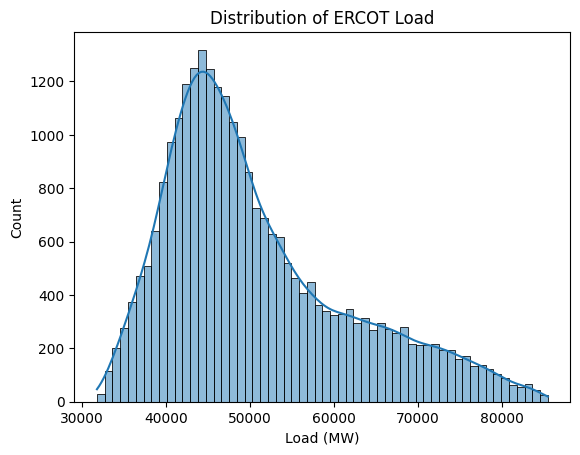

In [8]:
# Cell 2: Univariate Analysis - ERCOT Load

# Basic summary statistics
print("ERCOT Load Summary Statistics:")
print(df_load['ERCOT'].describe())

# Distribution plot
sns.histplot(df_load['ERCOT'], kde=True)
plt.title("Distribution of ERCOT Load")
plt.xlabel("Load (MW)")
plt.show()


ERCOT Solar Generation Summary Statistics:
count    26304.000000
mean      3926.581037
std       5242.853384
min          0.000010
25%          0.309680
50%        247.933716
75%       7593.807340
max      21588.538561
Name: ERCOT.PVGR.GEN, dtype: float64


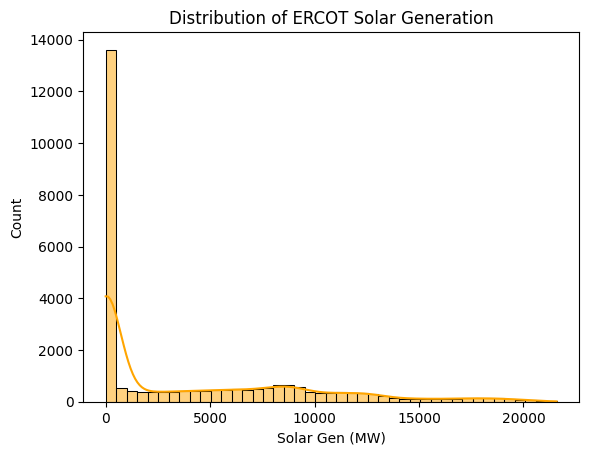

In [9]:
# Cell 3: Univariate Analysis - ERCOT Solar Generation

# Basic summary statistics
print("ERCOT Solar Generation Summary Statistics:")
print(df_solar['ERCOT.PVGR.GEN'].describe())

# Distribution plot
sns.histplot(df_solar['ERCOT.PVGR.GEN'], kde=True, color='orange')
plt.title("Distribution of ERCOT Solar Generation")
plt.xlabel("Solar Gen (MW)")
plt.show()


Correlation Matrix (Including ERCOT.LOAD, Excluding Date):
                              ERCOT.LOAD  ERCOT.PVGR.GEN  \
ERCOT.LOAD                      1.000000        0.459125   
ERCOT.PVGR.GEN                  0.459125        1.000000   
Total Solar Installed, MW       0.164157        0.222136   
Solar Output, % of Load         0.293142        0.966525   
Solar Output, % of Installed    0.437286        0.916894   
Solar 1-hr MW change           -0.182419        0.176289   
Solar 1-hr % change            -0.004268       -0.013304   

                              Total Solar Installed, MW  \
ERCOT.LOAD                                 1.641568e-01   
ERCOT.PVGR.GEN                             2.221357e-01   
Total Solar Installed, MW                  1.000000e+00   
Solar Output, % of Load                    1.968910e-01   
Solar Output, % of Installed              -2.903908e-02   
Solar 1-hr MW change                      -1.800796e-08   
Solar 1-hr % change                       -1.08

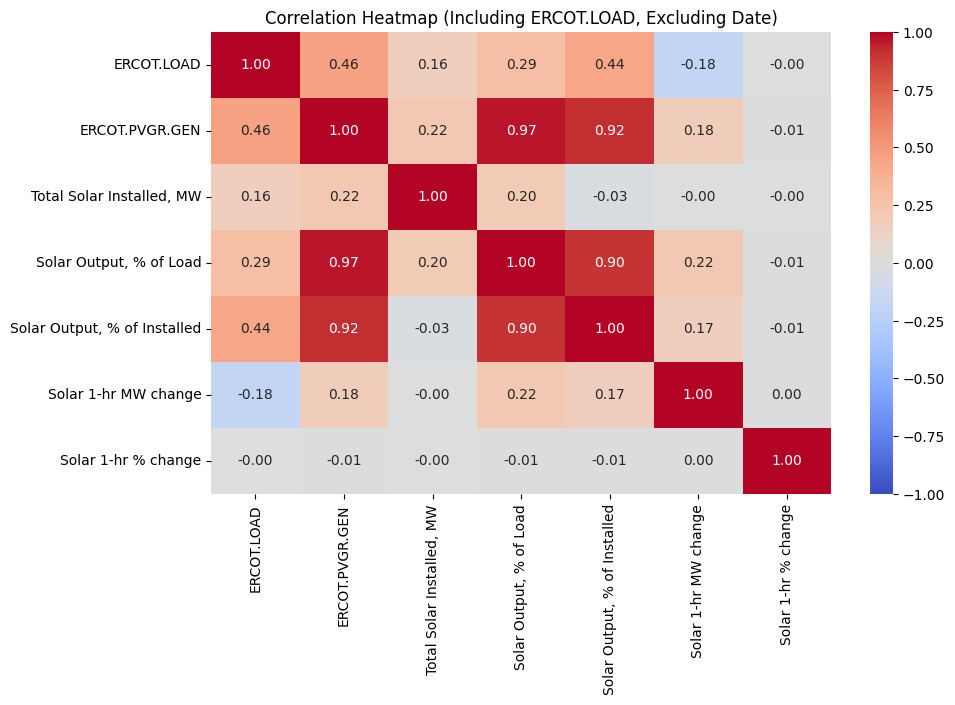

In [10]:
# Updated Cell: Correlation Matrix Including ERCOT.LOAD, Excluding Date

import seaborn as sns
import matplotlib.pyplot as plt

# 1) If your df_solar DataFrame includes 'Date' (or any other non-numeric columns),
#    we can drop them. If 'Date' isn't in df_solar, the 'errors="ignore"' just skips it.
df_solar_subset = df_solar.drop(columns=['Date'], errors='ignore')

# 2) Keep only numeric columns (float, int)
df_solar_subset = df_solar_subset.select_dtypes(include=['float', 'int'])

# 3) Compute correlation matrix (now includes ERCOT.LOAD, if present)
corr_solar = df_solar_subset.corr()

print("Correlation Matrix (Including ERCOT.LOAD, Excluding Date):")
print(corr_solar)

# 4) Visualize as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_solar, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap (Including ERCOT.LOAD, Excluding Date)")
plt.show()



In [11]:
print(df_wind.index)


DatetimeIndex(['2022-01-01 01:00:00', '2022-01-01 02:00:00',
               '2022-01-01 03:00:00', '2022-01-01 04:00:00',
               '2022-01-01 05:00:00', '2022-01-01 06:00:00',
               '2022-01-01 07:00:00', '2022-01-01 08:00:00',
               '2022-01-01 09:00:00', '2022-01-01 10:00:00',
               ...
               '2024-12-31 15:00:00', '2024-12-31 16:00:00',
               '2024-12-31 17:00:00', '2024-12-31 18:00:00',
               '2024-12-31 19:00:00', '2024-12-31 20:00:00',
               '2024-12-31 21:00:00', '2024-12-31 22:00:00',
               '2024-12-31 23:00:00', '2025-01-01 00:00:00'],
              dtype='datetime64[ns]', name='Time (Hour-Ending)', length=26304, freq=None)


Wind Data Summary Statistics:
                                Date    ERCOT.LOAD  ERCOT.WIND.GEN  \
count                          26304  26304.000000    26304.000000   
mean   2023-07-02 13:19:06.350365184  51015.805188    12434.722521   
min              2022-01-01 00:00:00  31949.182855       37.929258   
25%              2022-10-02 00:00:00  43043.745407     6789.362288   
50%              2023-07-03 00:00:00  48107.574158    12069.498196   
75%              2024-04-02 00:00:00  56990.053429    18021.886348   
max              2025-01-01 00:00:00  85544.435964    27666.564470   
std                              NaN  11019.851536     6591.169571   

       Total Wind Installed, MW  Wind Output, % of Load  \
count              26304.000000            26304.000000   
mean               37487.230117               25.809491   
min                34173.000000                0.078255   
25%                35653.000000               12.867781   
50%                37676.000000             

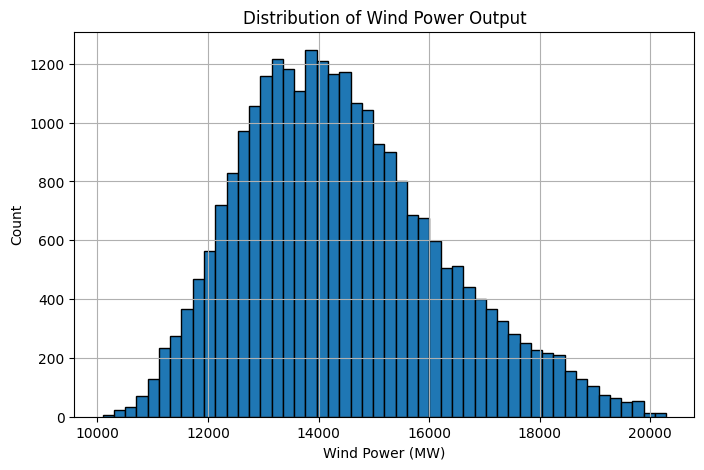

Correlation between Wind Power and Load:
COAST                         NaN
EAST                          NaN
ERCOT                         NaN
ERCOT.LOAD                    NaN
ERCOT.WIND.GEN                NaN
FWEST                         NaN
NCENT                         NaN
NORTH                         NaN
SCENT                         NaN
SOUTH                         NaN
Total Wind Installed, MW      NaN
WEST                          NaN
Wind 1-hr % change            NaN
Wind 1-hr MW change           NaN
Wind Output, % of Installed   NaN
Wind Output, % of Load        NaN
dtype: float64


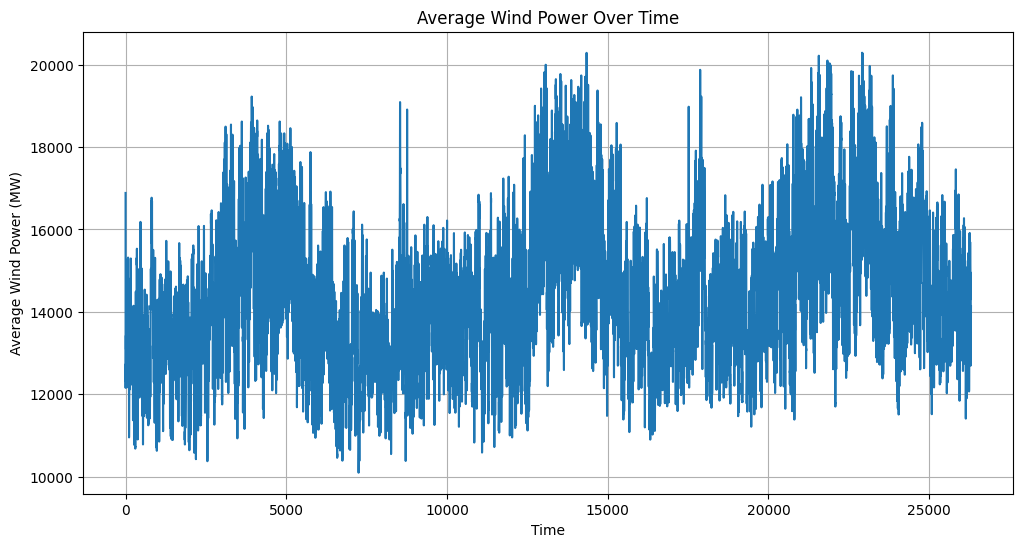

In [12]:

# Wind Data EDA

# Summary Statistics for Wind Data
print("Wind Data Summary Statistics:")
print(df_wind.describe())

# Handling Missing Values
num_na_wind = df_wind.isna().sum()
print(f"Missing values per column in wind data:\n{num_na_wind}")

# Convert datetime index to a column to avoid computation errors
df_wind_numeric = df_wind.reset_index()

# Ensure only numeric columns are used
df_wind_numeric = df_wind_numeric.select_dtypes(include=['number'])

# Visualizing Wind Power Distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
df_wind_numeric.mean(axis=1).hist(bins=50, edgecolor='black')
plt.title("Distribution of Wind Power Output")
plt.xlabel("Wind Power (MW)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Correlation Analysis: Wind vs Load
correlation_wind_load = df_wind_numeric.corrwith(df_load)
print(f"Correlation between Wind Power and Load:\n{correlation_wind_load}")

# Time Series Trend for Wind Power
df_wind_numeric.mean(axis=1).plot(figsize=(12,6), title="Average Wind Power Over Time")
plt.xlabel("Time")
plt.ylabel("Average Wind Power (MW)")
plt.grid(True)
plt.show()


In [43]:
#read in new data
df_weather = pd.read_csv("cleaned_combined_texas_weather_2022_2024.csv", index_col=0, parse_dates=True)
df_cloud = pd.read_csv("synced_texas_cloud_coverage_2022_2024.csv", index_col=0, parse_dates=True)

In [ ]:
print(df_load.columns.tolist)
print(df_load['ERCOT.NETLOAD'])

<bound method IndexOpsMixin.tolist of Index(['COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST',
       'ERCOT.NETLOAD'],
      dtype='object')>
2022-01-01 01:00:00    38006.938896
2022-01-01 02:00:00    37036.522365
2022-01-01 03:00:00    35881.607998
2022-01-01 04:00:00    35044.055105
2022-01-01 05:00:00    34585.571140
                           ...     
2024-12-31 19:00:00    48175.877538
2024-12-31 20:00:00    47619.264355
2024-12-31 21:00:00    46737.678611
2024-12-31 22:00:00    45775.649767
2024-12-31 23:00:00    44779.606498
Name: ERCOT.NETLOAD, Length: 25205, dtype: float64


Combined Load-Weather-Cloud Data (first 5 rows):


,ERCOT.NETLOAD,tavg,tmin,tmax,prcp,cloud_avg


Correlation of ERCOT Load with Weather and Cloud Variables:
tavg        NaN
tmin        NaN
tmax        NaN
prcp        NaN
cloud_avg   NaN
Name: ERCOT.NETLOAD, dtype: float64


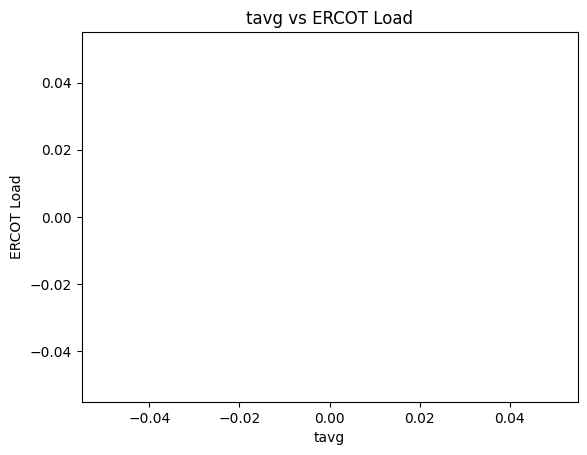

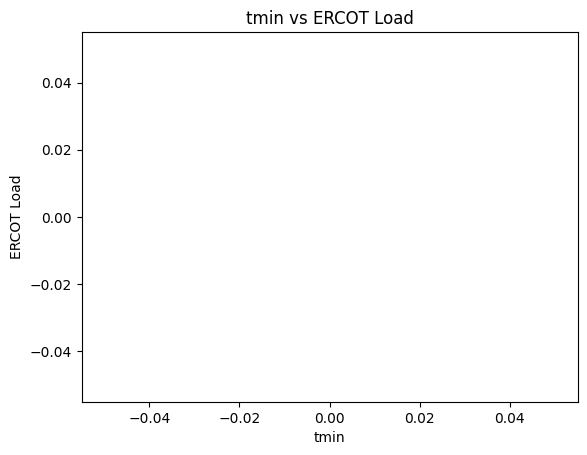

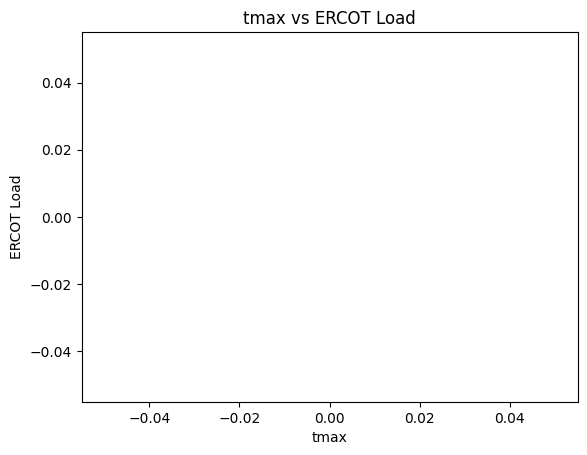

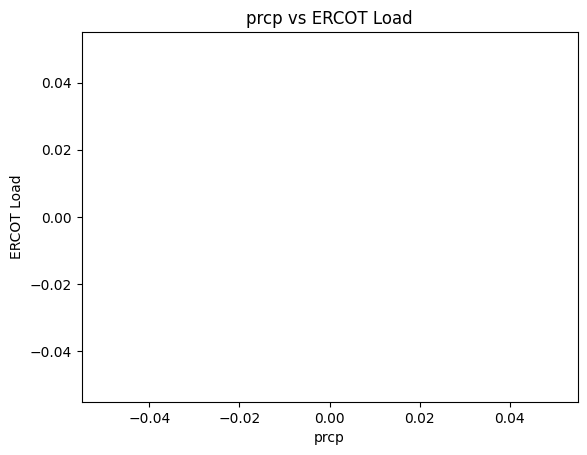

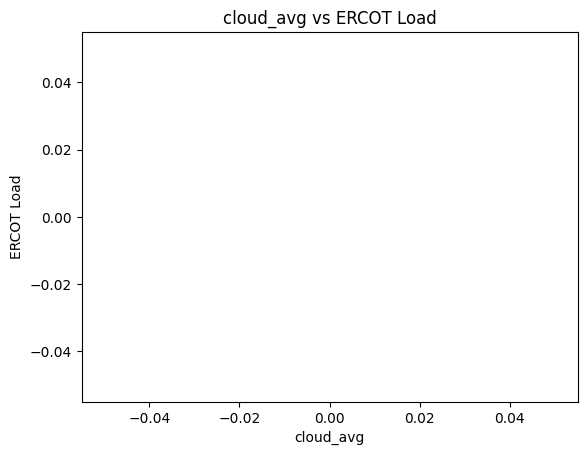

In [50]:
#EDA – Weather/Cloud Coverage vs ERCOT Load ***NOT WORKING PROPERLY***

#cloud avg
df_cloud["cloud_avg"] = df_cloud.mean(axis=1)

#inspect these weather variables
weather_vars = ['tavg', 'tmin', 'tmax', 'prcp']

#drop rows missing these variables
df_weather_sub = df_weather[weather_vars].dropna()

#join load data w weather
df_load_weather = df_load[['ERCOT.NETLOAD']].join(df_weather_sub, how='inner')

#join load data w/ cloud
df_load_weather = df_load_weather.join(df_cloud[['cloud_avg']], how='inner')

print("Combined Load-Weather-Cloud Data (first 5 rows):")
display(df_load_weather.head())

#pearson correlations between ERCOT load and each weather/cloud variable.
corr_vals = df_load_weather.corr()['ERCOT.NETLOAD'].drop('ERCOT.NETLOAD')
print("Correlation of ERCOT Load with Weather and Cloud Variables:")
print(corr_vals)

#scatter plots for each variable against load
for var in weather_vars + ['cloud_avg']:
    plt.figure()
    plt.scatter(df_load_weather[var], df_load_weather['ERCOT.NETLOAD'], alpha=0.3)
    plt.xlabel(var)
    plt.ylabel("ERCOT Load")
    plt.title(f"{var} vs ERCOT Load")
    plt.show()


Wind Comparison Data (first 5 rows):


,wdir,wspd,ERCOT.WIND.GEN
time,,,
2022-01-02,284.0,14.4,21549.239833
2022-01-02,336.0,14.0,21549.239833
2022-01-02,9.0,31.3,21549.239833
2022-01-02,332.0,24.5,21549.239833
2022-01-02,9.0,7.9,21549.239833


Correlation of ERCOT.WIND.GEN with wind direction and wind speed:
wdir    0.125285
wspd    0.432615
Name: ERCOT.WIND.GEN, dtype: float64


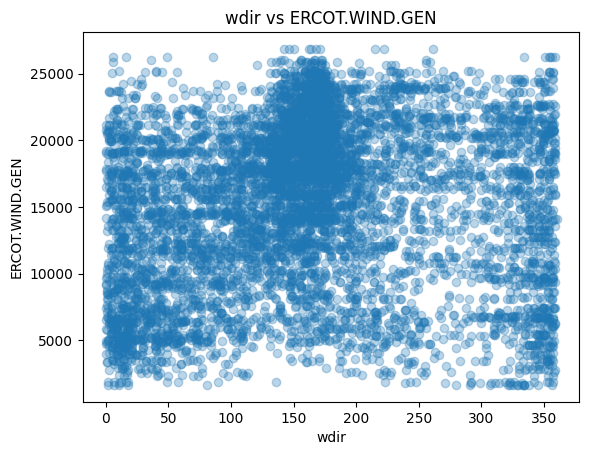

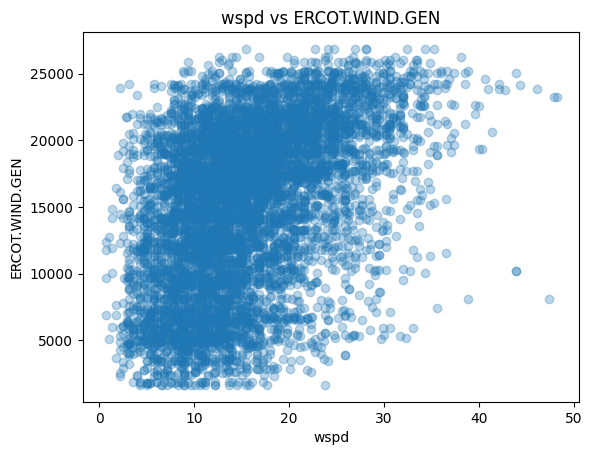

In [51]:
#Compare Wind Direction and Wind Speed vs ERCOT.WIND.GEN

#wind data from weather
df_weather_wind = df_weather[['wdir', 'wspd']].dropna()

df_wind_subset = df_wind[['ERCOT.WIND.GEN']].dropna()

#match by datetime
df_wind_compare = df_weather_wind.join(df_wind_subset, how='inner')

print("Wind Comparison Data (first 5 rows):")
display(df_wind_compare.head())

#print correlation
corr_wind = df_wind_compare[['wdir', 'wspd', 'ERCOT.WIND.GEN']].corr()['ERCOT.WIND.GEN'].drop('ERCOT.WIND.GEN')
print("Correlation of ERCOT.WIND.GEN with wind direction and wind speed:")
print(corr_wind)

#scatter plots for wdir and wind speed against ERCOT.WIND.GEN.
for var in ['wdir', 'wspd']:
    plt.figure()
    plt.scatter(df_wind_compare[var], df_wind_compare['ERCOT.WIND.GEN'], alpha=0.3)
    plt.xlabel(var)
    plt.ylabel("ERCOT.WIND.GEN")
    plt.title(f"{var} vs ERCOT.WIND.GEN")
    plt.show()


Temperature and Solar Generation Combined Data (first 5 rows):


,tavg,tmin,tmax,prcp,ERCOT.PVGR.GEN
time,,,,,
2022-01-02,-7.4,-13.8,6.7,0.0,0.457395
2022-01-02,2.4,-3.8,8.9,0.0,0.457395
2022-01-02,9.5,2.7,23.4,0.0,0.457395
2022-01-02,-2.9,-7.7,3.9,0.0,0.457395
2022-01-02,2.2,-4.3,6.7,0.0,0.457395


Correlations between Temperature Variables and ERCOT.PVGR.GEN:
tavg   -0.034432
tmin   -0.022116
tmax   -0.042124
prcp   -0.010637
Name: ERCOT.PVGR.GEN, dtype: float64


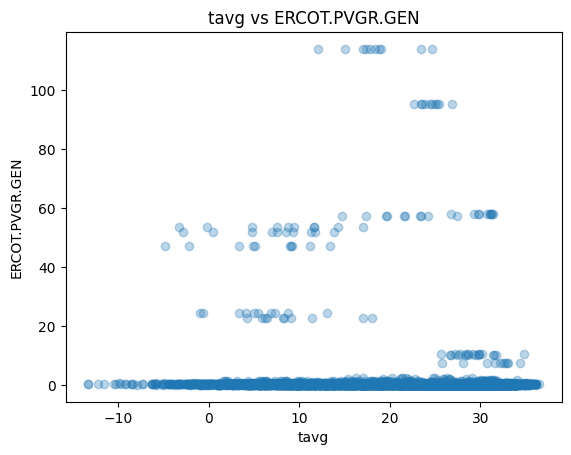

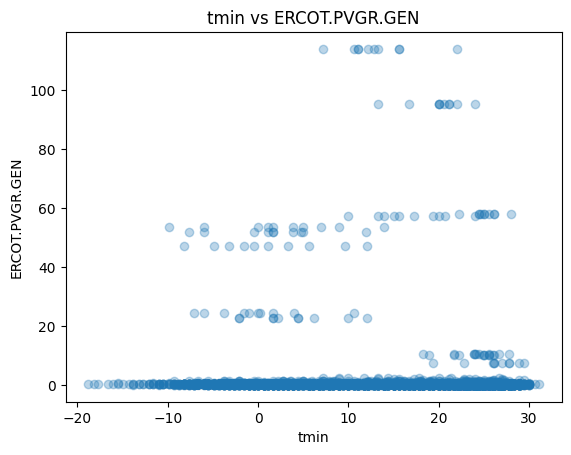

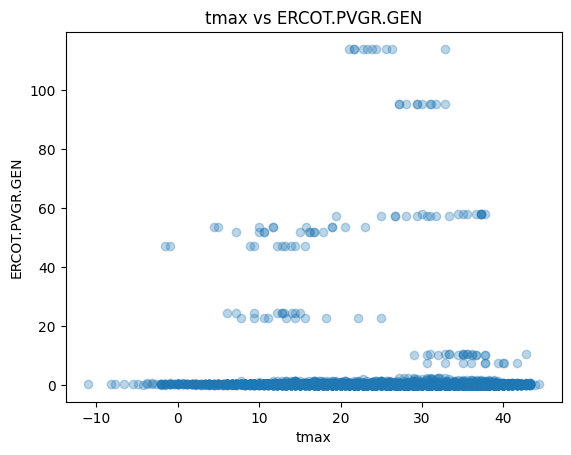

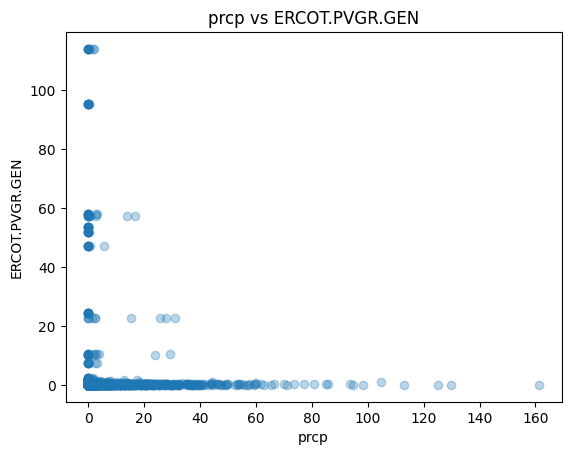

In [52]:
#Compare Temperature-related Variables vs ERCOT.PVGR.GEN

#temp variables from weather
temp_vars = ['tavg', 'tmin', 'tmax', 'prcp']
df_weather_temp = df_weather[temp_vars].dropna()

df_solar_sub = df_solar[['ERCOT.PVGR.GEN']].dropna()

#join on datetime
df_temp_solar = df_weather_temp.join(df_solar_sub, how='inner')

print("Temperature and Solar Generation Combined Data (first 5 rows):")
display(df_temp_solar.head())

#pearson correlations between temperature variables and solar generation
corr_temp_solar = df_temp_solar.corr()['ERCOT.PVGR.GEN'].drop('ERCOT.PVGR.GEN')
print("Correlations between Temperature Variables and ERCOT.PVGR.GEN:")
print(corr_temp_solar)

#scatter plots.
for var in temp_vars:
    plt.figure()
    plt.scatter(df_temp_solar[var], df_temp_solar['ERCOT.PVGR.GEN'], alpha=0.3)
    plt.xlabel(var)
    plt.ylabel("ERCOT.PVGR.GEN")
    plt.title(f"{var} vs ERCOT.PVGR.GEN")
    plt.show()
